In [1]:
### If save data:
save_data = False

if save_data:
  def ensure_dir(file_path):
    import os
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

  from google.colab import drive
  drive.mount('/content/drive')
  %cd drive/My Drive/
  save_dir = "Figs/"
  ensure_dir(save_dir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

!pip install -q git+https://github.com/Pehlevan-Group/kernel-generalization
from kernel_generalization.utils import gegenbauer
from kernel_generalization import kernel_spectrum as ker_spec

!git clone https://github.com/Pehlevan-Group/kernel-generalization.git
gegenbauer_dir = os.path.join(os.getcwd(),'kernel-generalization/PrecomputedData/GegenbauerEigenvalues.npz')
exp_dir = os.path.join(os.getcwd(),'kernel-generalization/PrecomputedData/SynthDataNTK_NN/')

Cloning into 'kernel-generalization'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 558 (delta 62), reused 0 (delta 0), pack-reused 433
Receiving objects: 100% (558/558), 21.84 MiB | 30.10 MiB/s, done.
Resolving deltas: 100% (315/315), done.


# Experiments without Ensembling

In [3]:
layer = 1
fn_mode = 1
width_list = [1000, 3500, 7000, 14000, 50000]

err_NN_all = []
std_NN_all = []
tr_err_NN_all = []
std_tr_err_NN_all = []

for w, width in enumerate(width_list):
  directory = exp_dir+'NNExp_width_%d-layer_%d-fn_mode_%d/'%(width,layer,fn_mode)
  error_theory = np.load(directory+'error_theory.npz', allow_pickle = True)
  error_exp_kernel = np.load(directory+'error_exp_kernel.npz')
  error_exp_NN = np.load(directory+'error_exp_NN.npz')

  pvals, Sol, Errs_tot, params = [error_theory['arr_'+str(i)] for i in range(len(error_theory.files))]
  params = params.tolist()
  alpha_s = params['alpha_s']
  degens = params['degens']
  dim = params['dim']
  kmax = params['kmax']
  layer = params['layer']
  noise = params['noise']
  num_iter_nn = params['num_iter_nn']
  num_repeat_nn = params['num_repeat_nn']
  num_repeat_ker = params['num_repeat_ker']
  test_samp = params['test_samp']
  width = params['width']

  err_regression, std_regression = [error_exp_kernel['arr_'+str(i)] for i in range(len(error_exp_kernel.files))]
  err_NN, std_NN, tr_err_NN, std_tr_err_NN = [error_exp_NN['arr_'+str(i)] for i in range(len(error_exp_NN.files))]

  err_NN_all += [err_NN]
  std_NN_all += [std_NN]
  tr_err_NN_all += [tr_err_NN]
  std_tr_err_NN_all += [std_tr_err_NN]

  shift = np.array([-0.8,0,1])
print(width)

50000


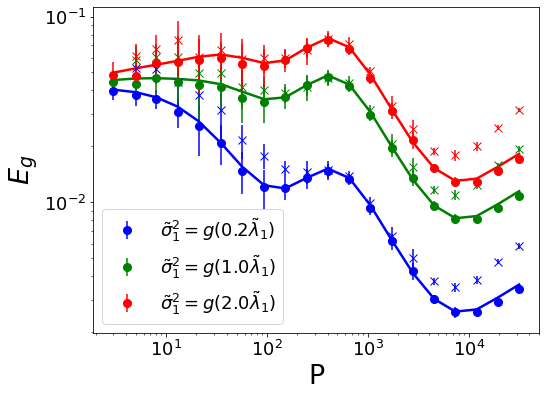

In [4]:
i = 0

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for j in range(len(shift)):
    k = 1+shift[j]
    plt.errorbar(pvals, err_regression[i,j], std_regression[i,j], fmt='o', markersize = 8,
                 label = r'$\tilde\sigma_1^2 = g(%.1f \tilde\lambda_1)$' % k, color=colors[j])
    plt.errorbar(pvals[1:], err_NN_all[-1][i,j][1:], std_NN_all[-1][i,j][1:], fmt='x', markersize = 8, color=colors[j])
    plt.plot(pvals, Errs_tot[j,:,i], color=colors[j], linewidth = 2.5)

plt.xlabel('P', fontsize= 27)
plt.ylabel('$E_g$', fontsize= 27)
plt.xscale('log')
plt.yscale('log')
plt.legend()
if save_data: plt.savefig(save_dir + 'nn_dim_25_layer_1.pdf', bbox_inches = 'tight')
plt.show()

### Width Comparison

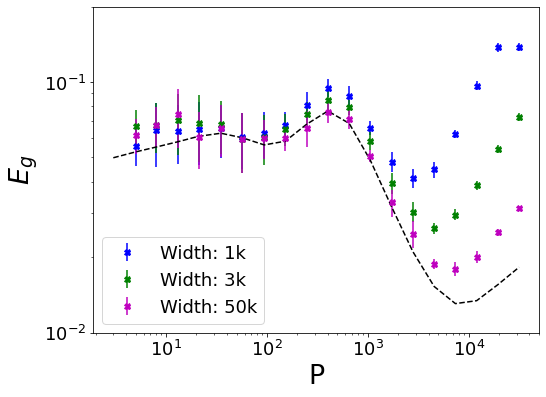

In [5]:
i = 0
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for j in range(2,3):
    k = 1+shift[j]
    plt.errorbar(pvals[1:], err_NN_all[0][i,j][1:], std_NN_all[0][i,j][1:], fmt='X',color=colors[0], label = 'Width: %dk' % 1)
    plt.errorbar(pvals[1:], err_NN_all[1][i,j][1:], std_NN_all[1][i,j][1:], fmt='X',color=colors[1], label = 'Width: %dk' % 3.5)
    #plt.errorbar(pvals[1:], err_NN70[i,j][1:], std_NN70[i,j][1:], fmt='X',color=colors[2], label = 'Width: %dk' % 7)
    #plt.errorbar(pvals[1:], err_NN140[i,j][1:], std_NN140[i,j][1:], fmt='X',color=colors[3], label = 'Width: %dk' % 14)
    plt.errorbar(pvals[1:], err_NN_all[-1][i,j][1:], std_NN_all[-1][i,j][1:], fmt='X',color=colors[4], label = 'Width: %dk' % 50)
    plt.plot(pvals, Errs_tot[j,:,i], '--', color='black')

plt.xlabel('P', fontsize= 27)
plt.ylabel('$E_g$', fontsize= 27)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e-1)
plt.legend(loc='lower left')
if save_data: plt.savefig(save_dir +'nn_width_comparison.pdf', bbox_inches = 'tight')
plt.show()

# Experiments with Ensembling

In [6]:
layer = 1
fn_mode = 1

width_list = [4000,8000]
shift = np.array([-0.8, 0, 1])

pvals_all = []
Errs_tot_all = []

err_regression_all = []
std_regression_all = []

err_NN_all = []
std_NN_all = []

for w, width in enumerate(width_list):
  parent = exp_dir + 'NNExp_width_%d-layer_%d-fn_mode_%d_ensembling/'%(width,layer,fn_mode)
  error_theory = np.load(parent+'error_theory.npz', allow_pickle = True)
  pvals, Sol, Errs_tot, params = [error_theory['arr_'+str(i)] for i in range(len(error_theory.files))]
  params = params.tolist()
  alpha_s = params['alpha_s']
  degens = params['degens']
  dim = params['dim']
  kmax = params['kmax']
  layer = params['layer']
  noise = params['noise']
  num_iter_nn = params['num_iter_nn']
  num_repeat_nn = params['num_repeat_nn']
  num_repeat_ker = params['num_repeat_ker']
  test_samp = params['test_samp']
  width = params['width']
  ensamble_list = params['ensemble_size_list']
  shift = params['shift']

  error_exp_kernel = np.load(parent+'error_exp_kernel.npz')
  err_regression, std_regression = [error_exp_kernel['arr_'+str(i)] for i in range(len(error_exp_kernel.files))]

  pvals_all += [pvals]
  Errs_tot_all += [Errs_tot]
  err_regression_all += [err_regression]
  std_regression_all += [std_regression]

  err_NN_all_ensmbl = []
  std_NN_all_ensmbl = []

  for ensmbl in ensamble_list:
    directory = exp_dir + 'NNExp_width_%d-layer_%d-fn_mode_%d_ensembling/ensamble_%d/'%(width,layer,fn_mode,ensmbl)
    error_exp_NN = np.load(directory+'error_exp_NN.npz', allow_pickle = True)

    err_NN, std_NN, tr_err_NN, std_tr_err_NN = [error_exp_NN['arr_'+str(i)] for i in range(len(error_exp_NN.files))]
    err_NN_all_ensmbl += [err_NN]
    std_NN_all_ensmbl += [std_NN]

  err_NN_all += [err_NN_all_ensmbl]
  std_NN_all += [std_NN_all_ensmbl]
num_repeat_ker

15

### NN - NTK Comparison without Ensembling

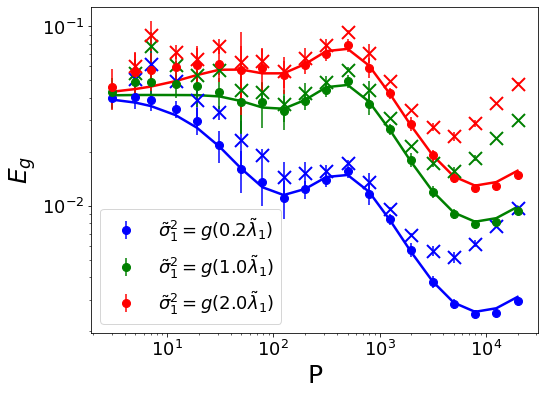

In [7]:
i = 0
w = 0
e = 0

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for j in range(len(shift)):
    k = 1+shift[j]
    plt.errorbar(pvals, err_regression_all[w][i,j], std_regression_all[w][i,j], fmt='o', markersize = 8,
                 label = r'$\tilde\sigma_1^2 = g(%.1f \tilde\lambda_1)$' % k, color=colors[j])
    plt.errorbar(pvals[1:], err_NN_all[w][e][i,j][1:], std_NN_all[w][e][i,j][1:], fmt='x',ms=13, mew=2, color=colors[j])
    plt.plot(pvals, Errs_tot_all[w][j,:,i], color=colors[j], linewidth = 2.5)

plt.xlabel('P', fontsize= 25)
plt.ylabel('$E_g$', fontsize= 25)
plt.xscale('log')
plt.yscale('log')
plt.legend()
if save_data: plt.savefig(save_dir+'nn_dim_%d_layer_%d.pdf'%(dim,layer), bbox_inches = 'tight')
plt.show()

### NN - NTK Comparison with Ensembling

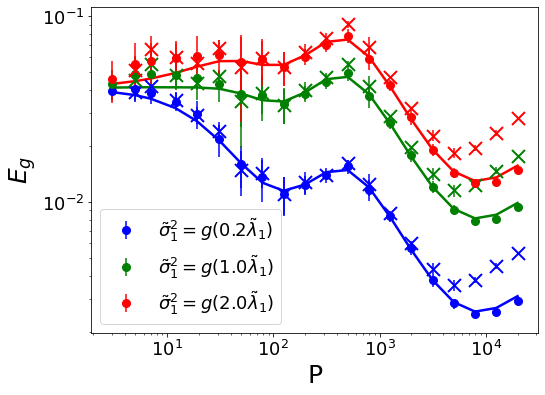

In [8]:
i = 0
w = 0
e = -1

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for j in range(len(shift)):
    k = 1+shift[j]
    plt.errorbar(pvals, err_regression_all[w][i,j], std_regression_all[w][i,j], fmt='o', markersize = 8,
                 label = r'$\tilde\sigma_1^2 = g(%.1f \tilde\lambda_1)$' % k, color=colors[j])
    plt.errorbar(pvals[1:], err_NN_all[w][e][i,j][1:], std_NN_all[w][e][i,j][1:], fmt='x',ms=13, mew=2, color=colors[j])
    plt.plot(pvals, Errs_tot_all[w][j,:,i], color=colors[j], linewidth = 2.5)

plt.xlabel('P', fontsize= 25)
plt.ylabel('$E_g$', fontsize= 25)
plt.xscale('log')
plt.yscale('log')
plt.legend()
if save_data: plt.savefig(save_dir+'nn_dim_%d_layer_%d_with_ensembling.pdf'%(dim,layer), bbox_inches = 'tight')
plt.show()

### Ensembling Figures

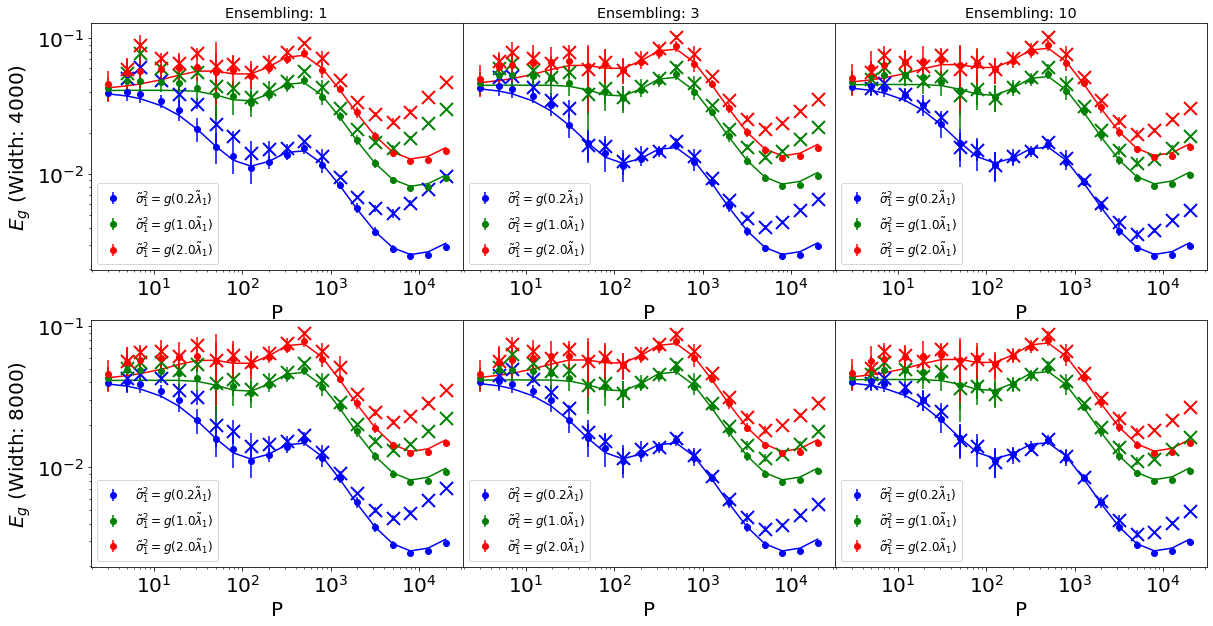

In [9]:
i = noise_idx = 0

plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(len(width_list),len(ensamble_list), figsize=(20,5*len(width_list)))
axs = axs.reshape(len(width_list),len(ensamble_list))
fontsize = '30'
plt.subplots_adjust(wspace=0)

for w, width in enumerate(width_list):
  for e, ensmb in enumerate(ensamble_list):

    plt.rcParams.update({'font.size': 12})
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for j in range(len(shift)):
        k = 1+shift[j]
        axs[w,e].errorbar(pvals, err_regression_all[w][i,j], std_regression_all[w][i,j], fmt='o', label = r'$\tilde\sigma_1^2 = g(%.1f \tilde\lambda_1)$' % k, color=colors[j])
        axs[w,e].errorbar(pvals[1:], err_NN_all[w][e][i,j][1:], std_NN_all[w][e][i,j][1:], fmt='x',color=colors[j],ms=13, mew=2)
        axs[w,e].plot(pvals, Errs_tot_all[w][j,:,i], color=colors[j])
    axs[0,e].set_title('Ensembling: %d'%ensamble_list[e])
    axs[w,e].set_xlabel('P', fontsize= 20)
    axs[w,e].set_ylabel('$E_g$'+' (Width: %d)'%(width), fontsize= 20)
    axs[w,e].set_xscale('log')
    axs[w,e].set_yscale('log')
    axs[w,e].get_yaxis().set_visible(False)
    axs[w,e].legend()

  axs[w,0].get_yaxis().set_visible(True)

if save_data: plt.savefig(save_dir+'nn_dim_%d_layer_%d_ensembling_comparison.pdf'%(dim,layer), bbox_inches = 'tight')
plt.show()

## Gegenbauer Decomposition, NTK Eigenvalues and Effective Regularization

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


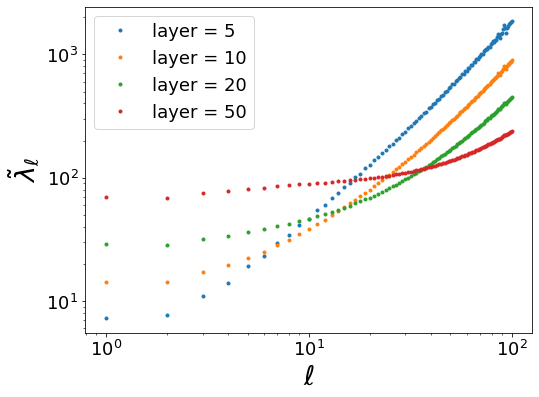

In [11]:
## Spectrum is numerically computed for the following parameters
## We only consider the NTK with weight variance = 1 and bias variance = 0
kmax = 250
layers = np.array([5,10,20,50])
sigma_w = 1
sigma_b = 0
dim = 20
degens = np.array([gegenbauer.degeneracy_kernel(dim, k) for k in range(kmax)])

def eff_regularizer(dim, layers):
    eff_reg = np.zeros((len(layers),kmax-2))
    
    for i in range(len(layers)):
        _,eta, etabar,_,_ = ker_spec.get_kernel_spectrum([layers[i]], sigma_w, sigma_b, kmax, dim, num_pts=10000)
        etabar = etabar[0]
        eff_reg[i] = np.array([np.sum(etabar[1+i:])/etabar[1+i] for i in range(kmax-2)])

    return eff_reg

eff_reg = eff_regularizer(dim, layers)

cut = 100
lambda_tilde = eff_reg[:,:cut]
k = np.linspace(1,cut,cut)

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
for i in range(len(layers)):
    plt.loglog(k, lambda_tilde[i],'.',label = 'layer = '+str(layers[i]));

plt.legend()
plt.xlabel('$\ell$', fontsize= 27)
plt.ylabel('$\\tilde\lambda_\ell$', fontsize= 27)
if save_data: plt.savefig(save_dir + 'ntk_effective_reg.pdf', bbox_inches = 'tight')

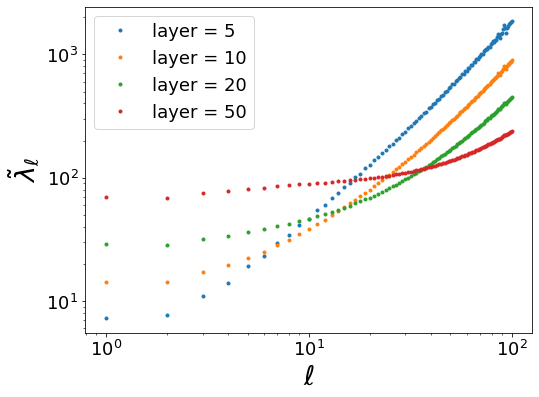

In [12]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
for i in range(len(layers)):
    plt.loglog(k, lambda_tilde[i],'.',label = 'layer = '+str(layers[i]));

plt.legend()
plt.xlabel('$\ell$', fontsize= 27)
plt.ylabel('$\\tilde\lambda_\ell$', fontsize= 27)
if save_data: plt.savefig(save_dir + 'ntk_effective_reg.pdf', bbox_inches = 'tight')

(40, 501, 10)


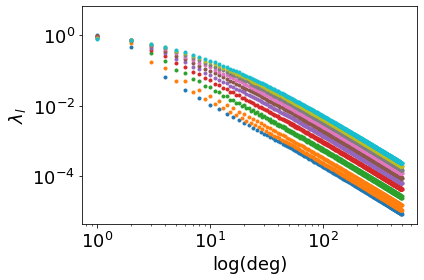

In [13]:
## Spectrum is numerically computed for the following parameters
## We only consider the NTK with weight variance = 1 and bias variance = 0
dim = np.array([5*(i+1) for i in range(40)])
deg = np.array([i for i in range(501)]); 
layer = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9,10]);

data = np.load(gegenbauer_dir, allow_pickle=True)
eig_etabar, eig_eta,_ = [data['arr_'+str(i)] for i in range(len(data.files))]
print(eig_etabar.shape)

dim_idx = 3
for i in range(layer.size):
    plt.loglog((deg),eig_etabar[dim_idx,:,i],'.',label = 'layer = '+str(layer[i]));
    
plt.xlabel('log(deg)')
plt.ylabel('$\lambda_l$')
plt.show()